# Reddit get-comment tool, covid-19 sentiment analysis

## Set-up

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import datetime as dt
import time
import requests
from bs4 import BeautifulSoup

In [17]:
sub_url = 'https://api.pushshift.io/reddit/search/submission'
comment_url = 'https://api.pushshift.io/reddit/search/comment'

#### Define subreddits, fields gathered

In [18]:
# Play with different localities here
subreddits = ['nyc', 'houston']

In [19]:
submission_fields = ['id','title', 'created_utc','num_comments','subreddit']
comment_fields = ['link_id','body','created_utc', 'subreddit', 'score']

#### Set key terms; Name data

In [20]:
# Batch name (suffix to add to all saved data)
prefix = '2020'

In [21]:
# Search terms
keywords = 'covid|quarantine|pandemic|coronavirus'

#### Set Time

In [22]:
# time flags (search starts at t2 and goes back by 'span_days' find t1)
# 86400 utc = 1 day

# Start Time
t2 = round(time.time()) # Now
# t2 = '1557446400' #5/10/2019, 12 am

# Search Span
span_days = 80

t1 = str(int(t2) - span_days*86400) 

## Submissions

In [ ]:
# get submissions
submissions = pd.DataFrame(columns = submission_fields)
df_list = []

for subreddit in subreddits:
    # start_time = t2
    start_time = round(time.time())
    res = requests.get(
        sub_url,
        params={
            'subreddit' : subreddit,
            'q' : keywords,
            'fields': submission_fields,
            'size' : 400,
            'sort_type' : 'num_comments',
            'sort' : 'desc',
            'before': start_time,  
            # 'after': t1,
        })
    # Make sure we got a 2xx response
    res.raise_for_status()

    df = pd.DataFrame(res.json()['data'])
    
    # Filter out non-commented; could also set 'sort_type' parameter to get most commented
    df = df[df['num_comments'] >0]
    
    df_list.append(df)

start_time = df.created_utc.min()
submissions = pd.concat(df_list, axis=0)
submissions['date'] = [dt.date.fromtimestamp(x).isoformat() for x in submissions['created_utc']]

## Comments

In [36]:
# Generate id dictionary for cross-referencing submissions with comments
link_ids = {sub: submissions[submissions["subreddit"] == sub]["id"] for sub in subreddits}

In [38]:
# get comments
df_list = []

for subreddit in subreddits:
    start_time = t2
    c = 0
    while c < submissions[submissions['subreddit'] == subreddit]['num_comments'].sum():
        time.sleep(2)
        res = requests.get(
            comment_url,
            params={
                'subreddit' : subreddit,
                'fields': comment_fields,
                'link_id' : (['t3_' + n for n in link_ids[subreddit]]),  #/comment?link_id : /submission?ids
                'size' : 1000,
                'before' : start_time,
            })
        # Make sure we got a 2xx response
        res.raise_for_status()

        # Don't parse data unless we got at least one post
        if len(res.json()['data']) == 0:
            break
        
        df = pd.DataFrame(res.json()['data'])

        # raise counter by number of rows in df
        c += df.shape[0]

        print(f"Fetched {c} comments from r/{subreddit}")

        df_list.append(df)
        start_time = df['created_utc'].min()
        
comments = pd.concat(df_list, axis=0)
comments['date'] = [dt.date.fromtimestamp(x).isoformat() for x in comments['created_utc']]

Fetched 1000 comments from r/nyc
Fetched 2000 comments from r/nyc
Fetched 3000 comments from r/nyc
Fetched 4000 comments from r/nyc
Fetched 5000 comments from r/nyc
Fetched 6000 comments from r/nyc
Fetched 7000 comments from r/nyc
Fetched 8000 comments from r/nyc
Fetched 9000 comments from r/nyc
Fetched 10000 comments from r/nyc
Fetched 11000 comments from r/nyc
Fetched 12000 comments from r/nyc
Fetched 13000 comments from r/nyc
Fetched 14000 comments from r/nyc
Fetched 15000 comments from r/nyc
Fetched 16000 comments from r/nyc
Fetched 17000 comments from r/nyc
Fetched 18000 comments from r/nyc
Fetched 19000 comments from r/nyc
Fetched 20000 comments from r/nyc
Fetched 21000 comments from r/nyc
Fetched 22000 comments from r/nyc
Fetched 23000 comments from r/nyc
Fetched 24000 comments from r/nyc
Fetched 25000 comments from r/nyc
Fetched 26000 comments from r/nyc
Fetched 27000 comments from r/nyc
Fetched 28000 comments from r/nyc
Fetched 29000 comments from r/nyc
Fetched 30000 comments 

## Sample/Save Data

In [39]:
# Fewest posts we got from a subreddit
smallest = comments['subreddit'].value_counts().min()

# Pare every subreddit down to this number by random sampling
comments_sampled = pd.concat([
        comments[comments['subreddit'] == subreddit].sample(smallest, random_state=101)
        for subreddit in subreddits
    ])

In [41]:
# verify we now have equal classes
comments_sampled['subreddit'].value_counts()

nyc        21171
houston    21171
Name: subreddit, dtype: int64

In [43]:
# Save to local hard drive with prefix
today = dt.date.today().isoformat()

comments.to_csv(f'../data/{prefix}_reddit-comments_all-{today}.csv.bz2', index=False, compression='bz2')
comments_sampled.to_csv(f'../data/{prefix}_reddit-comments_sampled-{today}.csv.bz2', index=False, compression='bz2')
submissions.to_csv(f'../data/{prefix}_reddit-submissions-{today}.csv.bz2', index=False, compression='bz2')

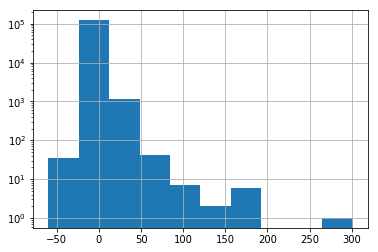

In [46]:
comments["score"].hist(log=True);